In [1]:
from rdkit import Chem
from rdkit.Chem.Scaffolds.MurckoScaffold import MurckoScaffoldSmiles
from rdkit.Chem.Draw import MolsMatrixToGridImage
from rdkit.Chem import Descriptors

In [2]:
smls = ["Cc1cc(Oc2nccc(CCC)c2)ccc1", "Cc1ccccc1", "Cc1cc(Oc2nccc(CCCC)c2)ccc1"]

In [3]:
sml_scaffold = {sml:MurckoScaffoldSmiles(sml) for sml in smls}
sml_scaffold

{'Cc1cc(Oc2nccc(CCC)c2)ccc1': 'c1ccc(Oc2ccccn2)cc1',
 'Cc1ccccc1': 'c1ccccc1',
 'Cc1cc(Oc2nccc(CCCC)c2)ccc1': 'c1ccc(Oc2ccccn2)cc1'}

In [4]:
scaffolds = set(scaffold for scaffold in sml_scaffold.values())
scaffolds

{'c1ccc(Oc2ccccn2)cc1', 'c1ccccc1'}

In [5]:
len(scaffolds)

2

In [6]:
# Create a dictionary to map each scaffold to its corresponding SMILES, realizing that there could be multiple SMILES for the same scaffold
scaffold_sml = dict()
for sml, scaffold in sml_scaffold.items():
    if scaffold not in scaffold_sml.keys():
        scaffold_sml[scaffold] = [sml]
    else:
        scaffold_sml[scaffold].append(sml)

In [ ]:
# Create a matrix of mols where the first column is the scaffold and subsequent columns are molecules with that scaffold
molsMatrix = []
for scaffold, smls_list in scaffold_sml.items():
    molsMatrix.append([Chem.MolFromSmiles(scaffold)] + [Chem.MolFromSmiles(sml) for sml in smls_list])

molsMatrix=[[<rdkit.Chem.rdchem.Mol object at 0x11904b530>, <rdkit.Chem.rdchem.Mol object at 0x11904b5a0>, <rdkit.Chem.rdchem.Mol object at 0x11904b610>], [<rdkit.Chem.rdchem.Mol object at 0x11904b680>, <rdkit.Chem.rdchem.Mol object at 0x11904b6f0>]]


In [ ]:
# Sort by molecular weight of scaffold
molsMatrix.sort(key=lambda x: Descriptors.MolWt(x[0]))

molsMatrix=[[<rdkit.Chem.rdchem.Mol object at 0x11904b680>, <rdkit.Chem.rdchem.Mol object at 0x11904b6f0>], [<rdkit.Chem.rdchem.Mol object at 0x11904b530>, <rdkit.Chem.rdchem.Mol object at 0x11904b5a0>, <rdkit.Chem.rdchem.Mol object at 0x11904b610>]]


In [9]:
legendsMatrix = []
for row_num, row in enumerate(molsMatrix, start=1):
    n_examples = len(row) - 1
    if n_examples == 1:
        descr = "1 molecule"
    else:
        descr = f"{n_examples} molecules"
    labelsRow = [f"Scaffold #{row_num}", descr]
    labelsRow += [""] * (n_examples - 1)
    legendsMatrix.append(labelsRow)

Todo:
- Highlight the scaffold in each molecule
- X Sort scaffolds by e.g. molecular weight

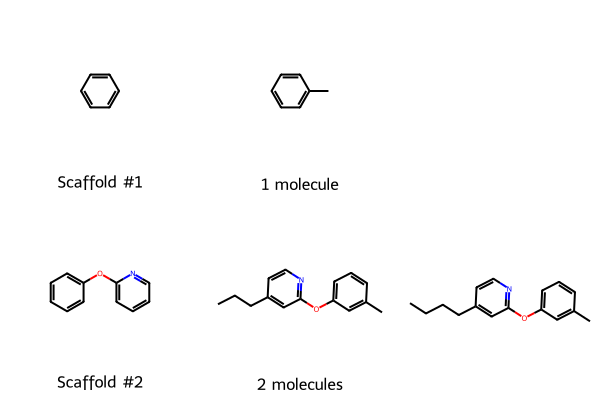

In [10]:
MolsMatrixToGridImage(
    molsMatrix=molsMatrix, 
    legendsMatrix=legendsMatrix,
)